In [1]:
import os, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from joblib import Parallel, delayed
import joblib as jl
import umap
from numba import jit
FNAME = 'C:/Users/Hsin-Yi/Documents/GitHub/spider-side-behavior/pipeline/python/wavelet_analysis/notebook/aligned/wavelet/wavelet.npz'
amplPCA = np.load(FNAME)
amplitudes_x = amplPCA['arr_0']
amplitudes_y = amplPCA['arr_1']
f = amplPCA['arr_2']
#from MulticoreTSNE import MulticoreTSNE as TSNE
from openTSNE import TSNE

In [2]:
tsne = TSNE(n_components=2,  perplexity=40, n_jobs=8).fit(amplitudes_y)
#tsne = TSNE(n_components=2,  perplexity=40, n_iter=2000).fit(amplitudes_y[::10,])

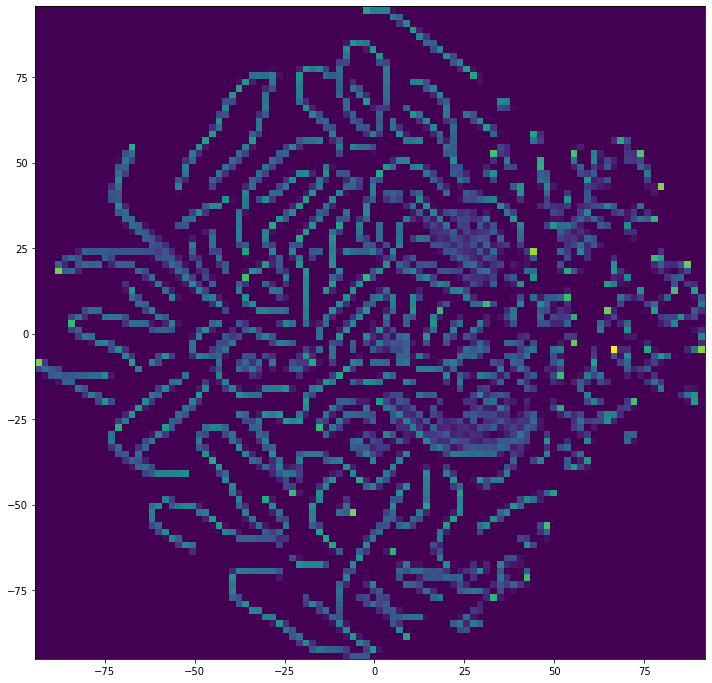

In [3]:
plt.figure(figsize=(12,12), facecolor='w')
plt.hist2d(tsne[:,0], tsne[:,1], bins=100)
plt.show()

In [ ]:
##### Abel's nb

In [8]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_jobs=60).fit_transform(amplPCA)

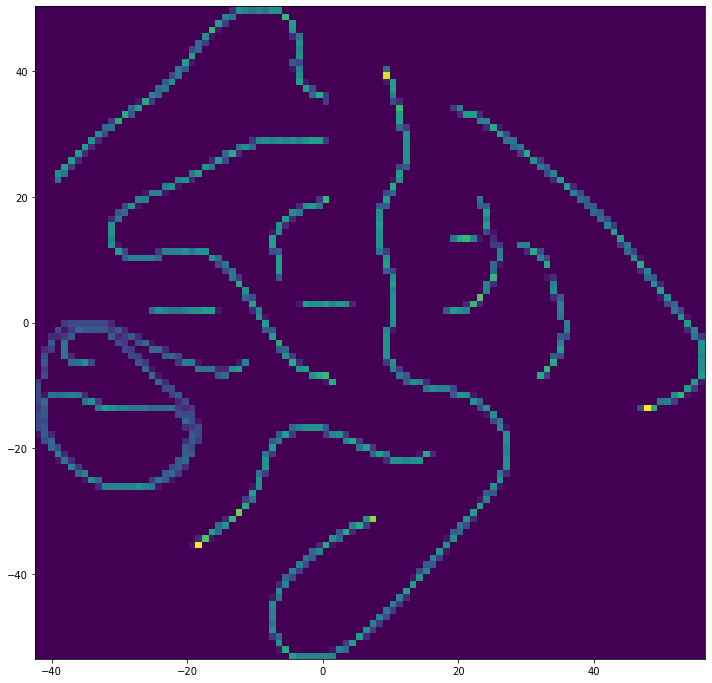

In [9]:
plt.figure(figsize=(12,12), facecolor='w')
plt.hist2d(tsne[:,0], tsne[:,1], bins=100)
plt.show()

In [10]:
FNAME_PCA = 'Z:/HsinYi/test/wavelet/wavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20.npy'
amplPCA = np.load(FNAME_PCA)
from MulticoreTSNE import MulticoreTSNE as TSNE

In [11]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_jobs=60).fit_transform(amplPCA[::10,])

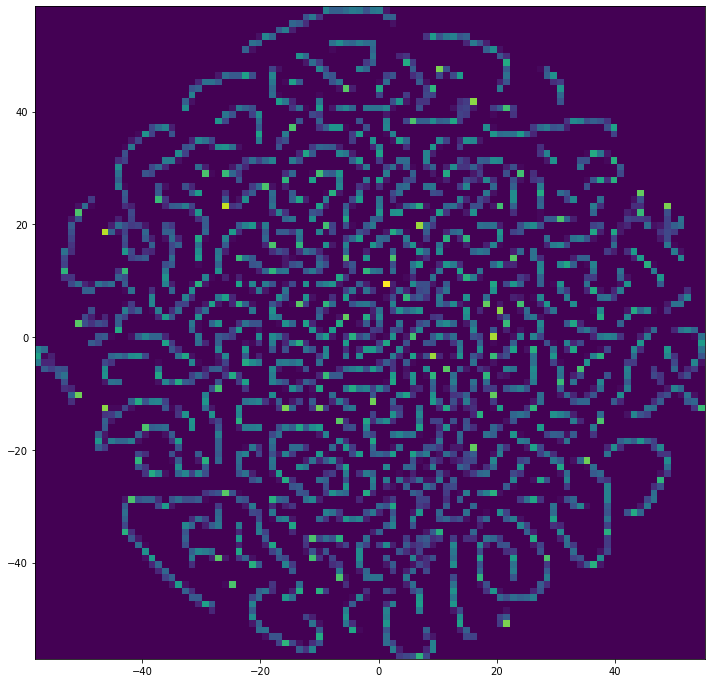

In [12]:
plt.figure(figsize=(12,12), facecolor='w')
plt.hist2d(tsne[:,0], tsne[:,1], bins=100)
plt.show()

In [5]:
import run_wavelet
#fnames = run_wavelet.listAvailableRecordings()

In [7]:
# =====================================================================================
# Merge wavelets
# =====================================================================================

settings = {
    'algorithm': 'dlc',
    # Include only front legs
    # 'joints': [0, 1, 2, 6, 10, 14, 18, 22, 5, 9, 13, 17, 21, 25],
    'joints': [1, 6, 10, 18, 22, 9, 13, 21, 25],
    # Overwrite?
    'overwrite': True,
    # Use polar coordinates w.r.t. previous limb?
    'coords': 'polar',
    'include_absolute_position': 'no-abspos',
    'include_velocities': 'no-vel',
    'use_pca': 'no-pca',
    #'numPeriods': numPeriods
}

settings = run_wavelet.checkSettings(settings)

# Concatenate the wavelet data
#fnamesWav = [run_wavelet.getWaveletFilename(d, settings) for d in fnames]
#fnamesWav
fnamesWav = r"C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\wavelet\wavelet_dlc_polar_no_abspos_no_vel_01000010011001000010011001_20.npy"

# Obtain number of rows/cols without reading data
shapes = [np.load(fnamesWav).shape]
nrows = np.sum([x[0] for x in shapes])
ncols = shapes[0][1]

In [8]:
FNAME_BASE = r"C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\wavelet"
FNAME_DATA      = lambda settings: '{}{}/{}.npy'.format          (FNAME_BASE, _getWaveletFilename(settings), _getWaveletFilename(settings))
FNAME_HIPOW     = lambda settings: '{}{}/{}_hipow.npy'.format    (FNAME_BASE, _getWaveletFilename(settings), _getWaveletFilename(settings))
FNAME_HIPOW_IDX = lambda settings: '{}{}/{}_hipow_idx.npy'.format(FNAME_BASE, _getWaveletFilename(settings), _getWaveletFilename(settings))
FNAME_PCA       = lambda settings: '{}{}/{}_hipow_pca.npy'.format(FNAME_BASE, _getWaveletFilename(settings), _getWaveletFilename(settings))
FNAME_POWER     = lambda settings: '{}{}/{}_pow.npy'.format      (FNAME_BASE, _getWaveletFilename(settings), _getWaveletFilename(settings))
FNAME_IDX       = lambda settings: '{}{}/{}_idx.npy'.format      (FNAME_BASE, _getWaveletFilename(settings), _getWaveletFilename(settings))
ACTIVITY_THRESHOLD = 0 # Power is now filtered at the coordinate level, so probably no need to filter again based on wavelet power

def _getWaveletFilename(settings):
    fn = run_wavelet.getWaveletFilename('', settings)
    fn = os.path.basename(fn)
    fn = fn.replace('.npy','')

    return fn

import numpy as np, matplotlib.pyplot as plt, sys, os, gc, pandas as pd, logging, \
    datashader as ds, datashader.transfer_functions as tf, umap, imageio, joblib as jl, time, copy, json, numba


In [9]:
    if not os.path.exists(FNAME_DATA(settings)) or settings['overwrite']:
        os.makedirs(os.path.dirname(FNAME_DATA(settings)), exist_ok=True)

        # Merge data into single file
        data = None

        # Determine maximum filename length
        fnameMaxLen = max([len(f) for f in fnamesWav])

        # Keep index of filenames
        idx = np.zeros(nrows, dtype={'names': ('file', 'index'), 'formats': (np.dtype(('U', fnameMaxLen)), np.int64)})

        # Keep track of power
        pw = np.zeros(nrows, dtype=np.float32)

        # Save all data into this array
        curr = 0
        f = fnamesWav
        # Merge data
        print('Processing: {}'.format(f))
        mtx = np.load(f, mmap_mode=None)
        gc.collect()
        print('4c: {}'.format(f))
        BLOCK_SIZE = 100000
        for i in range(0, mtx.shape[0], BLOCK_SIZE):
            pw[(curr + i):(curr + min(i + BLOCK_SIZE, mtx.shape[0]))] = \
                np.nansum(np.square(mtx[i:(i+BLOCK_SIZE),:]), axis=1)

        # Keep index
        _idx = []
        print('2: {}'.format(f))
        for _i in np.arange(mtx.shape[0], dtype=np.int64): _idx.append( (f, _i) )
        print('3: {}'.format(f))
        idx[curr:(curr + mtx.shape[0])] = _idx

        # Option 1: Scale by mean
        #pw[curr:(curr + mtx.shape[0])] *= 1000.0 / np.nanmean(pw[curr:(curr + mtx.shape[0])])

        # Option 2: Scale by Nth percentile... This should ensure the same number of rows are sampled from
        #           each dataset.
        print('5: {}'.format(f))
        pw[curr:(curr + mtx.shape[0])] *= 1000.0 / np.percentile(pw[curr:(curr + mtx.shape[0])], ACTIVITY_THRESHOLD)

        print('1: {}'.format(f))
        if data is None:
            data = np.memmap(filename=FNAME_DATA(settings), mode='w+', shape=(nrows, ncols), dtype=np.float32)
        data[curr:(curr + mtx.shape[0]), :] = mtx

        # Next
        curr += mtx.shape[0]

        # Clear memory
        print('6: {}'.format(f))
        del mtx
        gc.collect()
        print('7: {}'.format(f))

    # Save power and index
    np.save(FNAME_POWER(settings), pw)
    np.save(FNAME_IDX(settings), idx)

    # Delete data object
    del data
    del pw
    gc.collect()
        

Processing: C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\wavelet\wavelet_dlc_polar_no_abspos_no_vel_01000010011001000010011001_20.npy
4c: C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\wavelet\wavelet_dlc_polar_no_abspos_no_vel_01000010011001000010011001_20.npy
2: C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\wavelet\wavelet_dlc_polar_no_abspos_no_vel_01000010011001000010011001_20.npy
3: C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\wavelet\wavelet_dlc_polar_no_abspos_no_vel_01000010011001000010011001_20.npy
5: C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\wavelet\wavelet_dlc_polar_no_abspos_no_vel_01000010011001000010011001_20.npy
1: C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\wavelet\wavelet_dlc_pol

0

In [10]:
# =====================================================================================
# Filter by power (from wavelet power)
# =====================================================================================

"""
This function filters the wavelet data based on the power of the wavelet transform output.
"""
# Check settings
settings = run_wavelet.checkSettings(settings)

# Open merged files
pw = np.load(FNAME_POWER(settings))
idx = np.load(FNAME_IDX(settings), mmap_mode='r')
fnameData = FNAME_DATA(settings)
ampl = np.memmap(filename=fnameData, mode='r', dtype=np.float32)
nrows = pw.shape[0]
ncols = int(ampl.size / nrows)
del ampl
ampl = np.memmap(filename=fnameData, mode='r', shape=(nrows, ncols), dtype=np.float32)

# Only filter by power
if not os.path.exists(FNAME_HIPOW(settings)) or settings['overwrite']:

    # Determine what rows to keep
    subset = pw > np.percentile(pw, ACTIVITY_THRESHOLD)

    # Randomly sample a fixed number of frames (10k) from each video, to make sure no one video dominates the
    # dimensionality reduction space
    idxNames = np.array([x[0] for x in idx])
    subsetNew = subset.copy()
    subsetNew[:] = False
    for _fn in np.unique(idxNames):
        subsetRandom = np.random.choice(np.argwhere(idxNames==_fn).T[0], 1000, replace=False)
        subsetNew[subsetRandom] = True
    subset = subsetNew

    # New number of rows
    nr = np.sum(subset)
    logging.info('Keeping {} rows from file {}'.format(nr, fnameData))

    # Save subsetted dataset
    amplHiPow = np.memmap(filename=FNAME_HIPOW(settings), mode='w+', shape=(nr, ncols), dtype=np.float32)
    amplHiPow[:, :] = ampl[subset]
    del amplHiPow
    gc.collect()

    # Save subsetted index
    idxHiPow = idx[subset]
    np.save(FNAME_HIPOW_IDX(settings), idxHiPow)


INFO:root:Keeping 1000 rows from file C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\waveletwavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20/wavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20.npy


In [111]:

# =====================================================================================
# PCA
# =====================================================================================
from sklearn.decomposition.pca import PCA

settings = run_wavelet.checkSettings(settings)

# Already processed?
fnamePCA = FNAME_PCA(settings)
if os.path.exists(fnamePCA) and not settings['overwrite']:
    logging.info('Skipping PCA computation for: {}'.format(fnamePCA))
else:
    logging.info('Running PCA on: {}'.format(FNAME_PCA(settings)))

# Open merged files
idx = np.load(FNAME_HIPOW_IDX(settings), mmap_mode='r')

ampl = np.memmap(filename=FNAME_HIPOW(settings), mode='r', dtype=np.float32)
nrows = idx.shape[0]
ncols = int(ampl.size / nrows)
del ampl
ampl = np.memmap(filename=FNAME_HIPOW(settings), mode='r', shape=(nrows, ncols), dtype=np.float32)

# Generate a dataset where each of the columns (wavelets) is shuffled in time (so variance stays the same
# but correlations are removed)
amplShuffled = ampl.copy()
for i in tqdm(range(0, amplShuffled.shape[1], 10), leave=False):
    amplShuffled[:, i:(i + 10)] = amplShuffled[np.random.permutation(amplShuffled.shape[0]), i:(i + 10)]
gc.collect()

# Fit PCA to both
pca = PCA().fit(ampl)
pcaShuff = PCA().fit(amplShuffled)

# The number of components to keep
_nComponents = np.argwhere(pcaShuff.singular_values_ > pca.singular_values_)[0, 0]

# Make sure the number of components is not less than 10
nComponents = max(_nComponents, 10)
logging.info('PCA coordinates to keep based on shuffling is {}, but kept {}'.format(
    _nComponents, nComponents))

# Transform, filter, and transform back
amplPCA = pca.transform(ampl)
amplPCA[:, nComponents:] = 0
amplPCAorg = pca.inverse_transform(amplPCA)

logging.info('PCA-transformed data (#components={}), and transformed back (#features={})'.format(
    nComponents, amplPCAorg.shape[1]))

# Save PCA values
np.save(fnamePCA, amplPCAorg)
logging.info('Saved {}'.format(fnamePCA))



INFO:root:Running PCA on: C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\waveletwavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20/wavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20_hipow_pca.npy


INFO:root:PCA coordinates to keep based on shuffling is 1, but kept 10
INFO:root:PCA-transformed data (#components=10), and transformed back (#features=320)
INFO:root:Saved C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\waveletwavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20/wavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20_hipow_pca.npy


In [113]:
# =====================================================================================
# Main clustering function
# =====================================================================================

settings = run_wavelet.checkSettings(settings)

# Run UMAP
configs = []

SETTINGS_METHOD     = ['tsne',] #'umap',
SETTINGS_N          = [200000,] # [1000, 10000, 100000, 1000000, 5000000]
SETTINGS_ITER       = [5000,]
SETTINGS_METRIC     = 'JS'
SETTINGS_PERPLEXITY = [100, 500] #, 1000]
SETTINGS_MINDIST    = [0.1,]
SETTINGS_NEIGHBORS  = [20, 100, 500]

USE_DASK = False

for N in SETTINGS_N:
    for n_iter in SETTINGS_ITER:
        s = copy.copy(settings)
        s['fname'] = FNAME_PCA(s) if s['use_pca'] else FNAME_HIPOW(s)
        s['maxN'] = N
        s['n_iter'] = n_iter
        s['metric'] = SETTINGS_METRIC

        logging.info('Using file {}'.format(s['fname']))

        for method in SETTINGS_METHOD:
            s['method'] = method

            if method == 'umap':
                for min_dist in SETTINGS_MINDIST:
                    for neighbors in SETTINGS_NEIGHBORS:
                        s['min_dist']  = min_dist
                        s['n_neighbors'] = neighbors
                        configs.append( copy.copy(s) )

            elif method == 'tsne':

                for perplexity in SETTINGS_PERPLEXITY:
                    s['perplexity'] = perplexity
                    configs.append(copy.copy(s))

# DEBUG
#configs = [[x for x in configs if 'dlc' in x['algorithm']][0],]

# Randomize execution order to balance task sizes
np.random.shuffle(configs)

# If only one task is present, run it in this process (makes debugging easier)
if len(configs) == 1:
    runDimensionalityReduction(configs[0])

elif False and USE_DASK:
    # If multiple tasks are present, dispatch them to the Dask server, which will continue running these tasks
    # and exit this script. This allows multiple jobs to be dispatched from this same script.
    from dask.distributed import Client, fire_and_forget
    client = Client('localhost:8786')
    for c in configs:
        fire_and_forget(client.submit(runDimensionalityReduction, c))

else:
    # Otherwise, fire a new commmand prompt for every task
    import subprocess
    for c in configs:
        cf = { 'command': 'runDimensionalityReduction', 'params': c }
        cmd = '{} {} {}'.format(
            os.path.abspath(os.path.join(os.__file__, os.pardir, os.pardir, 'python.exe')),
            s['fname'],
            json.dumps(cf).replace("'",'"').replace('"','\\"') )
        print("Starting shell....")
        print(cmd)

        CREATE_NEW_PROCESS_GROUP = 0x00000200
        DETACHED_PROCESS = 0x00000008
        subprocess.Popen(cmd, shell=True, close_fds=True,
                            creationflags=DETACHED_PROCESS | CREATE_NEW_PROCESS_GROUP)

INFO:root:Using file C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\waveletwavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20/wavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20_hipow.npy


Starting shell....
C:\Users\hsinyi\Anaconda3\python.exe C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\waveletwavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20/wavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20_hipow.npy {\"command\": \"runDimensionalityReduction\", \"params\": {\"algorithm\": \"dlc\", \"joints\": \"01000010011001000010011001\", \"overwrite\": true, \"coords\": \"polar\", \"include_absolute_position\": \"no-abspos\", \"include_velocities\": \"no-vel\", \"use_pca\": false, \"numPeriods\": 20, \"fname\": \"C:\\Users\\hsinyi\\Documents\\GitHub\\spider-behavior\\pipeline\\python\\behavioral_motifs\\simulation\\waveletwavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20/wavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20_hipow.npy\", \"maxN\": 200000, \"n_iter\": 5000, \"metric\": \"JS\", \"method\": \"tsne\", \"perplexity\": 100}}
Starting shell....
C:\Users\hsinyi\Anaconda

In [12]:
import os, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from joblib import Parallel, delayed
import joblib as jl
import umap
from numba import jit

FNAME_PCA = r'C:\Users\hsinyi\Documents\GitHub\spider-behavior\pipeline\python\behavioral_motifs\simulation\waveletwavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20\wavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20_hipow_pca.npy'
amplPCA = np.load(FNAME_PCA)



ValueError: Cannot load file containing pickled data when allow_pickle=False

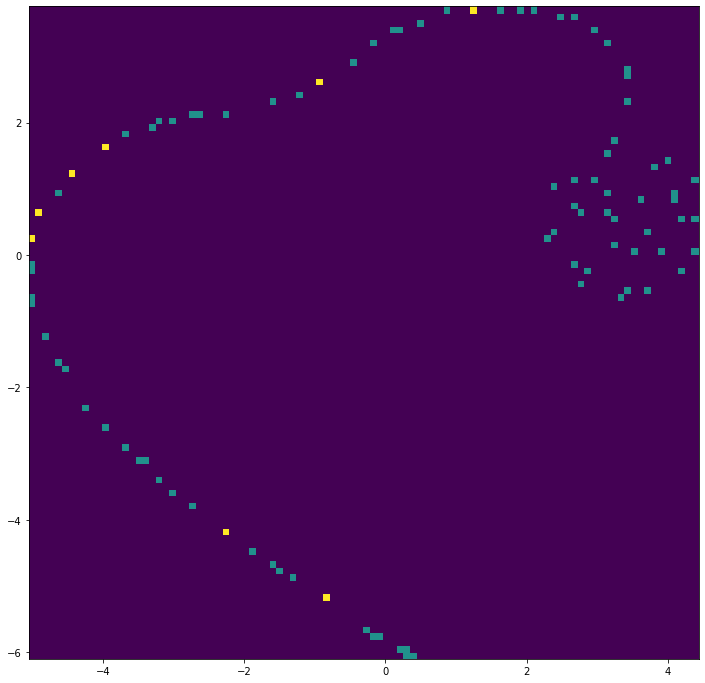

In [2]:
# Load PCA'ed data (computed in explore_behavioral_modes) [SLOW]
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(amplPCA)
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_jobs=60).fit_transform(amplPCA[::10,])
plt.figure(figsize=(12,12), facecolor='w')
plt.hist2d(tsne[:,0], tsne[:,1], bins=100)
plt.show()

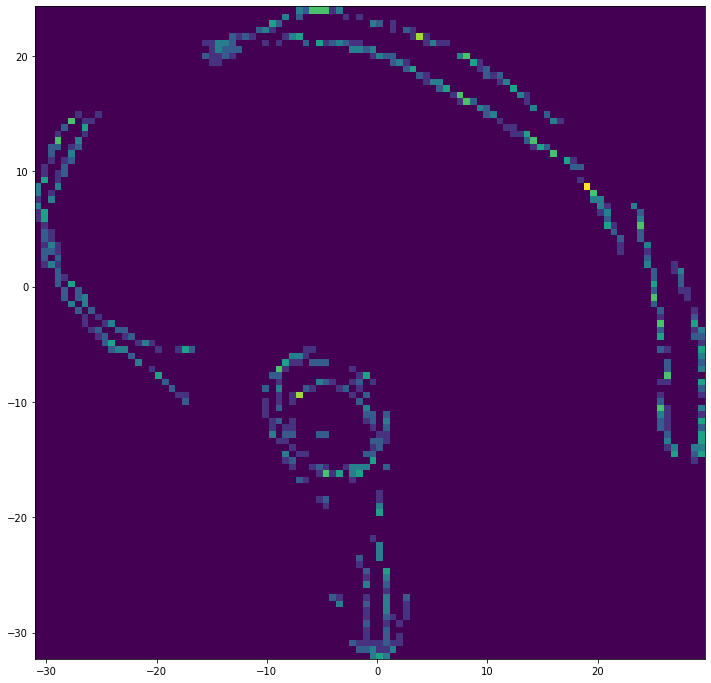

In [2]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_jobs=60).fit_transform(amplPCA)
plt.figure(figsize=(12,12), facecolor='w')
plt.hist2d(tsne[:,0], tsne[:,1], bins=100)
plt.show()

In [18]:
import run_wavelet, run_wavelet_cluster

settings = {
    'algorithm': 'dlc',
    # Include only front legs
    # 'joints': [0, 1, 2, 6, 10, 14, 18, 22, 5, 9, 13, 17, 21, 25],
    'joints': [1, 6, 10, 18, 22, 9, 13, 21, 25],
    # Overwrite?
    'overwrite': True,
    # Use polar coordinates w.r.t. previous limb?
    'coords': 'polar',
    'include_absolute_position': 'no-abspos',
    'include_velocities': 'no-vel',
    'use_pca': 'no-pca',
    #'numPeriods': numPeriods
}

dirOut = 'C:/Users/acorver/Desktop/testspider_3/'
run_wavelet_cluster.runWaveletMerge(settings)



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'Z:/behavior/190528_RIG2_SPIDER0002~\\wavelet/wavelet_dlc_polar_no-abspos_no-vel_01000010011001000010011001_20.npy'